In [80]:
# Imports & OU simulator 
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_ou(mu_series: torch.Tensor, theta: float, sigma: float, dt: float) -> torch.Tensor:
    """
    Simulate an Ornstein–Uhlenbeck path around a time-varying mean series.
    """
    dt_t    = torch.tensor(dt)
    sqrt_dt = torch.sqrt(dt_t)
    T       = mu_series.shape[0]
    P       = torch.zeros(T)
    P[0]    = mu_series[0]
    
    for t in range(1, T):
        drift     = theta * (mu_series[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t]      = P[t-1] + drift + diffusion

    return P



In [81]:
# Simulate all three series

# common settings
T          = 10_000
dt         = 1.0 / T
mu0        = 50.0
trend_rate = 0.01
regime_len = 500

# 1) Up-trend
mu_trend  = mu0 + trend_rate * torch.arange(T, dtype=torch.float)
P_trend   = simulate_ou(mu_trend,  theta=2.0,  sigma=20.0, dt=dt).numpy()

# 2) Mean-reverting (flat mean)
mu_flat   = mu0 * torch.ones(T)
P_flat    = simulate_ou(mu_flat,   theta=20.0, sigma=50.0, dt=dt).numpy()

# 3) Switching trend
mu_switch = torch.zeros(T)
mu_switch[0] = mu0
for t in range(1, T):
    sign = 1 if ((t // regime_len) % 2 == 0) else -1
    mu_switch[t] = mu_switch[t-1] + sign * trend_rate
P_switch = simulate_ou(mu_switch, theta=7.5, sigma=10.0, dt=dt).numpy()


In [82]:
# Prepare DataFrames

# build one DataFrame per series
df_trend  = pd.DataFrame({'Price': P_trend},  index=pd.RangeIndex(T, name='Time'))
df_flat   = pd.DataFrame({'Price': P_flat},   index=pd.RangeIndex(T, name='Time'))
df_switch = pd.DataFrame({'Price': P_switch}, index=pd.RangeIndex(T, name='Time'))

series_dict = {
    'Up-Trend':                df_trend,
    'Mean-Reverting (Flat)':   df_flat,
    'Switching-Trend':         df_switch
}


In [83]:
# Compute Signals & PnL


FAST, SLOW, TAU = 10, 27, 1.0
results = {}

for name, df in series_dict.items():
    # moving averages
    df[f'MA_{FAST}'] = df['Price'].rolling(window=FAST).mean()
    df[f'MA_{SLOW}'] = df['Price'].rolling(window=SLOW).mean()
    df = df.dropna().copy()
    
    # thresholded crossover: +1 if MA_fast - MA_slow > TAU; -1 if < -TAU; 0 otherwise
    df['Signal'] = np.where(
        df[f'MA_{FAST}'] - df[f'MA_{SLOW}'] >  TAU,  1,
        np.where(
            df[f'MA_{FAST}'] - df[f'MA_{SLOW}'] < -TAU, -1,
            0
        )
    )
    # shift to avoid look-ahead bias
    df['Signal'] = df['Signal'].shift(1).fillna(0)
    
    # returns & cumulative PnL
    df['Return']       = df['Price'].pct_change().fillna(0)
    df['Strat_CumPnL'] = (1 + df['Return'] * df['Signal']).cumprod() - 1
    df['BH_CumPnL']    = (1 + df['Return']).cumprod() - 1
    
    results[name] = df



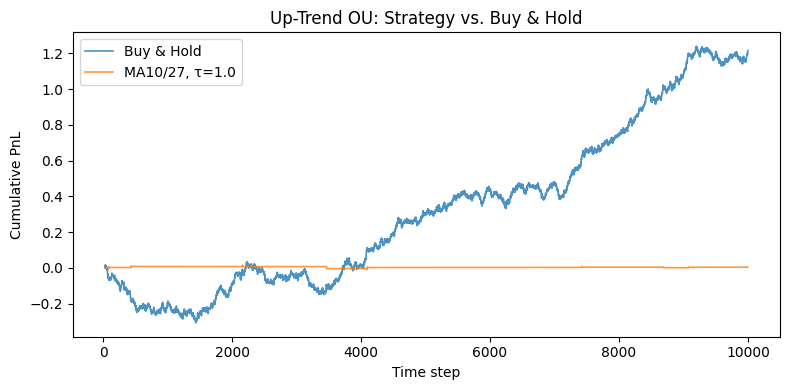

In [84]:
# Plot Up-Trend vs. Buy & Hold

df = results['Up-Trend']
plt.figure(figsize=(8, 4))
plt.plot(df['BH_CumPnL'],    label='Buy & Hold',        linewidth=1.2, alpha=0.8)
plt.plot(df['Strat_CumPnL'], label=f'MA{FAST}/{SLOW}, τ={TAU}', linewidth=1.2, alpha=0.8)
plt.title('Up-Trend OU: Strategy vs. Buy & Hold')
plt.xlabel('Time step')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.tight_layout()
plt.show()



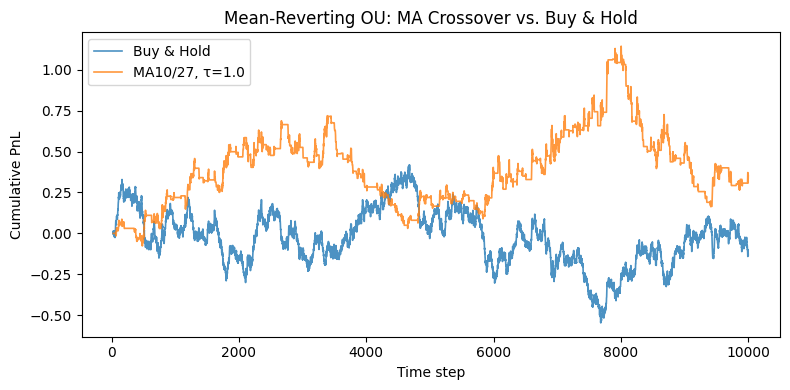

In [85]:
# Plot Mean-Reverting vs. Buy & Hold

df = results['Mean-Reverting (Flat)']

plt.figure(figsize=(8, 4))
plt.plot(df['BH_CumPnL'],    label='Buy & Hold',        linewidth=1.2, alpha=0.8)
plt.plot(df['Strat_CumPnL'], label=f'MA{FAST}/{SLOW}, τ={TAU}', linewidth=1.2, alpha=0.8)
plt.title('Mean-Reverting OU: MA Crossover vs. Buy & Hold')
plt.xlabel('Time step')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.tight_layout()
plt.show()


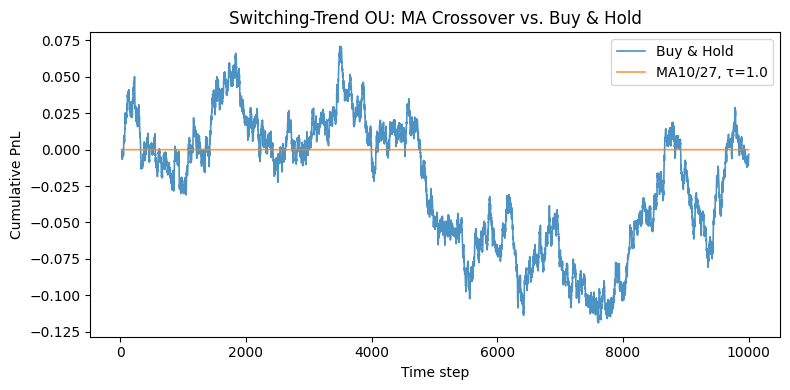

In [ ]:
df = results['Switching-Trend']         

plt.figure(figsize=(8, 4))
plt.plot(df['BH_CumPnL'],    label='Buy & Hold',        linewidth=1.2, alpha=0.8)
plt.plot(df['Strat_CumPnL'], label=f'MA{FAST}/{SLOW}, τ={TAU}', linewidth=1.2, alpha=0.8)
plt.title('Switching-Trend OU: MA Crossover vs. Buy & Hold')
plt.xlabel('Time step')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.tight_layout()
plt.show()